# Customer Segmentation using KMeans Clustering

## Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Dataset Glossary

This dataset is designed for learning customer segmentation concepts, such as market basket analysis. It includes basic customer data such as Customer ID, age, gender, annual income, and spending score, which is assigned based on customer behavior and purchasing data. The goal is to help a supermarket mall owner understand their customers better, identify target customers who are likely to converge, and provide insights to the marketing team for strategic planning.

## Load the data

In [53]:
df = pd.read_csv('../../datasets/customers.csv')
df.isna().sum()
df.head(11)


,Customer ID,Age,Gender,Annual Income,Spending Score
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,30,Male,151479,89
1,1770b26f-493f-46b6-837f-4237fb5a314e,58,Female,185088,95
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,62,Female,70912,76
3,9795712a-ad19-47bf-8886-4f997d6046e3,23,Male,55460,57
4,64139426-2226-4cd6-bf09-91bce4b4db5e,24,Male,153752,76
5,7e211337-e92f-4140-8231-5c9ac7a2aa12,42,Male,158335,40
6,30661d57-eeb5-4886-970a-9c7d0f260ad8,27,Female,163501,37
7,43417ade-6b17-431e-ae76-d8ed26aa46ac,24,Male,70476,17
8,86f73b1a-6a91-4d7e-ad21-0aefcf6111cc,83,Male,47743,34
9,b20fe0a0-e254-4116-b804-5403bb2f59ea,62,Female,63448,3


In [54]:
df.describe()
df.drop(['Customer ID'], axis=1, inplace=True)


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             15079 non-null  int64 
 1   Gender          15079 non-null  object
 2   Annual Income   15079 non-null  int64 
 3   Spending Score  15079 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 471.3+ KB


In [56]:
gender_map = {'Male': 1, 'Female': 2}
df['Gender'] = df['Gender'].map(gender_map)

df.head()

,Age,Gender,Annual Income,Spending Score
0,30,1,151479,89
1,58,2,185088,95
2,62,2,70912,76
3,23,1,55460,57
4,24,1,153752,76


Text(0.5, 1.0, 'Correlation Heatmap')

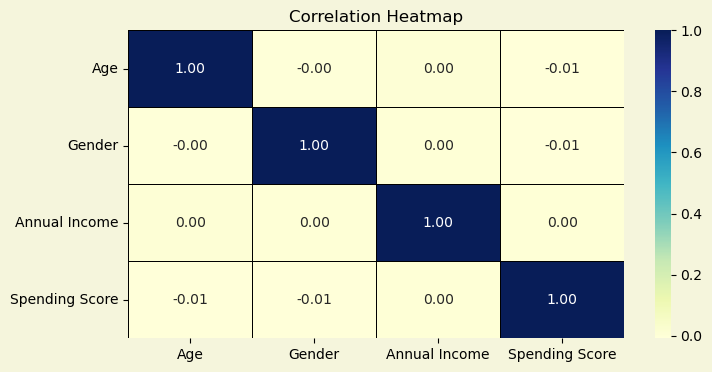

In [57]:
plt.figure(figsize=(8, 4), facecolor='beige')
# sns.heatmap(df.corr(), annot=True,  cmap=sns.dark_palette("#00eaff", as_cmap=True))
sns.heatmap(df.corr(), annot=True, linewidth=0.5,  fmt=".2f",  cmap="YlGnBu", linecolor="black")
plt.title("Correlation Heatmap")

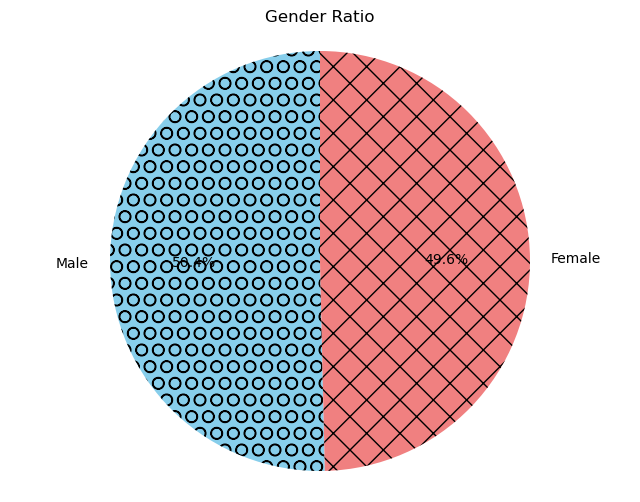

In [58]:
# Count the number of males and females
# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(df['Gender'].value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'], hatch=['O', 'X'],)
plt.title('Gender Ratio')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Text(0, 0.5, 'Count')

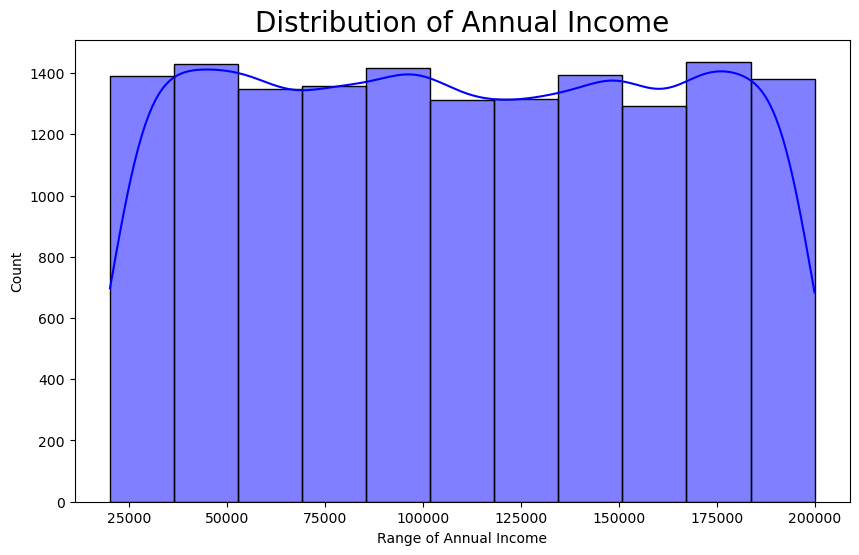

In [59]:
#Distribution of Annnual Income
plt.figure(figsize=(10, 6))

sns.histplot(df['Annual Income'], kde=True, color='blue', element='bars', bins=11)
plt.title('Distribution of Annual Income', fontsize = 20)
plt.xlabel('Range of Annual Income')
plt.ylabel('Count')

## Preprocessing

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# Split data
Train, Test = train_test_split(df, test_size=0.2, random_state=42)


scaler = StandardScaler()
Train_scaled = scaler.fit_transform(Train)
# Train = pca.fit_transform(Train)
# # Test = scaler.transform(Test)

def manual_pca(data, n_components):
    """
    Performs Principal Component Analysis (PCA) from scratch.
    Returns transformed data, components, and explained variance ratio.
    """
    # Center the data
    data_mean = np.mean(data, axis=0)
    centered_data = data - data_mean

    # Calculate covariance matrix
    n_samples = data.shape[0]
    covariance_matrix = np.dot(centered_data.T, centered_data) / (n_samples - 1)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Select top n_components
    components = eigenvectors[:, :n_components]
    
    # Project the data
    transformed_data = np.dot(centered_data, components)
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    
    return transformed_data, components, explained_variance_ratio

# Apply manual PCA
Train_pca, components, explained_variance = manual_pca(Train_scaled, n_components=2)

# Print the explained variance to understand how much information we retained
print("Explained variance ratios:", explained_variance)
print("Total variance explained:", sum(explained_variance))

Train.shape

Explained variance ratios: [0.25273678 0.25086833]
Total variance explained: 0.5036051135878361


(12063, 4)

## K-means Clustering Model


In [61]:
def euclidean_distance(x1, x2):
    """Randomly initialize k centroids from the data points."""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def initialize_centroids(data, k):
    """Initialize k centroids randomly from the data points."""
    n_samples = data.shape[0]
    random_indices = np.random.choice(n_samples, k, replace=False)
    return data[random_indices]

def assign_clusters(data, centroids):
    """Assign each data point to the nearest centroid."""
    distances = np.zeros((data.shape[0], len(centroids)))
    for i, centroid in enumerate(centroids):
        distances[:, i] = np.sqrt(np.sum((data - centroid) ** 2, axis=1))
    return np.argmin(distances, axis=1)

def update_centroids(data, clusters, k):
    """Update centroids based on mean of assigned points."""
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)
        else:
            # Handle empty cluster by choosing a random point
            centroids[i] = data[np.random.randint(data.shape[0])]
    return centroids

def k_means(data, k, max_iterations=100, tolerance=1e-4):
    """
    Perform K-means clustering on the data.
    Returns centroids and cluster assignments.
    """
    # Convert data to numpy array if it isn't already
    data = np.array(data)
    
    # Initialize centroids
    centroids = initialize_centroids(data, k)
    
    for _ in range(max_iterations):
        # Assign clusters
        clusters = assign_clusters(data, centroids)
        
        # Update centroids
        new_centroids = update_centroids(data, clusters, k)
        
        # Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            break
            
        centroids = new_centroids
    
    return centroids, clusters

## Elbow Method

Completed k=1
Completed k=2
Completed k=3
Completed k=4
Completed k=5
Completed k=6
Completed k=7
Completed k=8
Completed k=9
Completed k=10


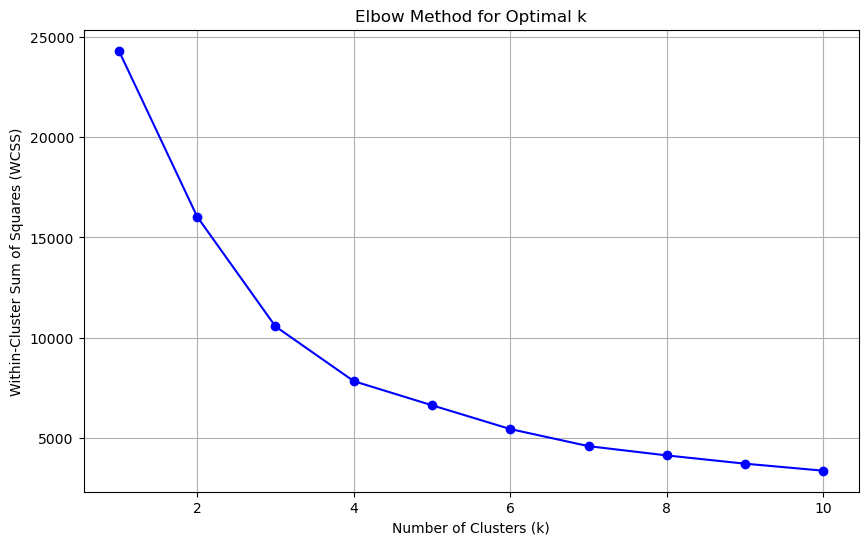

In [62]:
def calculate_wcss(data, centroids, clusters):
    """Calculate Within-Cluster Sum of Squares."""
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            wcss += np.sum((cluster_points - centroids[i]) ** 2)
    return wcss

def elbow_method(data, k_range):
    """
    Perform elbow method to find optimal k.
    Returns WCSS values for each k.
    """
    wcss_values = []
    data = np.array(data)  # Ensure data is numpy array
    
    for k in k_range:
        centroids, clusters = k_means(data, k)
        wcss = calculate_wcss(data, centroids, clusters)
        wcss_values.append(wcss)
        print(f"Completed k={k}")
    
    return wcss_values

# Run elbow method
k_range = range(1, 11)
wcss_values = elbow_method(Train_pca, k_range)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


## Running K-means Clustering

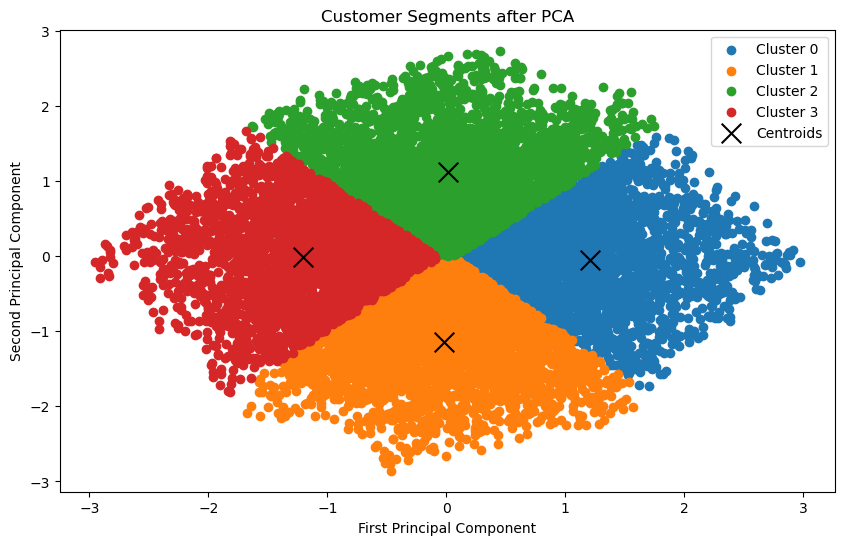

In [63]:
k = 4 # Number of clusters
centroids, clusters = k_means(Train_pca, k)

plt.figure(figsize=(10, 6))
for i in range(k):
    cluster_points = Train_pca[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=200, label='Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments after PCA')
plt.legend()
plt.show()

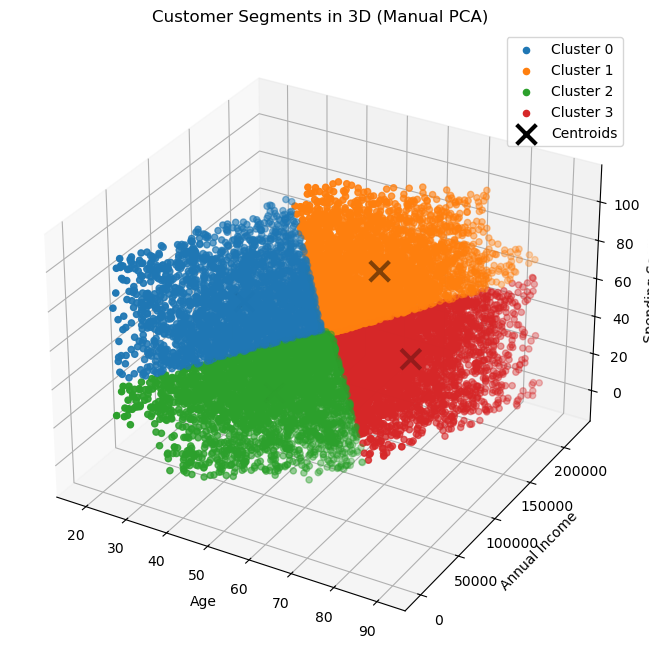

In [64]:
# To create the 3D visualization, we need to inverse transform the data
# We can reconstruct the original-scale data using the components
def inverse_transform_pca(transformed_data, components, original_mean):
    """Reconstruct the original-scale data from PCA transformation."""
    reconstructed = np.dot(transformed_data, components.T)
    return reconstructed + original_mean

# Get the original scale data for visualization
original_mean = np.mean(Train_scaled, axis=0)
reconstructed_data = inverse_transform_pca(Train_pca, components, original_mean)
original_data = scaler.inverse_transform(reconstructed_data)

# Create 3D visualization
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for i in range(k):
    cluster_points = original_data[clusters == i]
    ax.scatter(cluster_points[:, 0],  # Age
              cluster_points[:, 2],   # Annual Income
              cluster_points[:, 3],   # Spending Score
              label=f'Cluster {i}')

# Plot centroids in original space
centroid_points = inverse_transform_pca(centroids, components, original_mean)
centroid_points = scaler.inverse_transform(centroid_points)
ax.scatter(centroid_points[:, 0], 
          centroid_points[:, 2], 
          centroid_points[:, 3], 
          c='black', 
          marker='x', 
          s=200, 
          linewidth=3, 
          label='Centroids')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
ax.set_title('Customer Segments in 3D (Manual PCA)')
plt.legend()
plt.show()

In [67]:
# print("PCA components:")
# print(pca.components_)
# print("\nVariance explained by each component:")
# print(pca.explained_variance_ratio_)

## Implementation using sklearn

In [73]:
# from sklearn.cluster import KMeans
# # Apply KMeans with k=3
# optimal_k = 3
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# kmeans.fit(Train_pca)

# # Get cluster labels and centroids
# labels = kmeans.labels_
# centroids = kmeans.cluster_centers_

# plt.figure(figsize=(10, 6))

# # Plot clusters
# for i in range(optimal_k):
#     cluster_points = Train[labels == i]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

# # Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=200, label='Centroids')

# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.title('Customer Segmentation (2D)')
# plt.legend()
# plt.show()



InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1000x600 with 0 Axes>

In [72]:

# # After your k-means clustering, add this code:

# # Create a 3D scatter plot
# fig = plt.figure(figsize=(8, 12))
# ax = fig.add_subplot(111, projection='3d')

# # Get the original data back from scaled values
# original_data = scaler.inverse_transform(pca.inverse_transform(Train))

# # Plot each cluster
# for i in range(k):
#     cluster_points = original_data[clusters == i]
#     ax.scatter(cluster_points[:, 0],  # Age
#               cluster_points[:, 2],   # Annual Income
#               cluster_points[:, 3],   # Spending Score
#               label=f'Cluster {i}')

# # Plot centroids
# centroid_points = scaler.inverse_transform(pca.inverse_transform(centroids))
# ax.scatter(centroid_points[:, 0], 
#           centroid_points[:, 2], 
#           centroid_points[:, 3], 
#           c='black', 
#           marker='x', 
#           s=200, 
#           linewidth=3, 
#           label='Centroids')

# # Set labels and title
# ax.set_xlabel('Age')
# ax.set_ylabel('Annual Income')
# ax.set_zlabel('Spending Score')
# ax.set_title('Customer Segments in 3D')

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()

# # Optional: Add ability to rotate the plot
# plt.show(block=True)